<a href="https://colab.research.google.com/github/pachterlab/GVFP_2021/blob/dev/gg220806_monod_standalone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identification of CIR- and $\Gamma$-OU-like genes

In the current notebook, we attempt to find genes that consistently with the CIR and $\Gamma$-OU models of stochastic time-dependent transcription, as well as genes that cannot be confidently assigned to one of the two models.

## Colab prerequisites

In [2]:
!git clone https://github.com/pachterlab/monod.git

fatal: destination path 'monod' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.insert(0, './monod/src/')

In [3]:
!git clone --branch dev https://github.com/pachterlab/GVFP_2021.git

Cloning into 'GVFP_2021'...
remote: Enumerating objects: 1912, done.
remote: Counting objects: 100% (558/558), done.
remote: Compressing objects: 100% (321/321), done.
remote: Total 1912 (delta 247), reused 548 (delta 237), pack-reused 1354
Receiving objects: 100% (1912/1912), 846.36 MiB | 34.63 MiB/s, done.
Resolving deltas: 100% (811/811), done.
Checking out files: 100% (613/613), done.


In [4]:
!mv GVFP_2021/* .

In [7]:
!rm -r GVFP_2021

In [19]:
%%capture
!wget https://raw.githubusercontent.com/pachterlab/monod_examples/main/polyA_ref/gg_200524_mouse_genome_polyA_cum_1
#not strictly necessary

In [8]:
subcluster_loom_dir = './loom/'

In [10]:
transcriptome_filepath = 'gg_200524_mouse_genome_polyA_cum_1'

In [18]:
%%capture
!pip install loompy anndata numdifftools

## Predictive filtering: prerequisites

First, we do a round of preliminary filtering using five moderate- to high-abundance glutamatergic cell subtypes from four mice, released by the Allen brain institute. This requires the *Monod* framework.

In [11]:
import time
t1 = time.time()

Define the dataset metadata and disk locations.

In [12]:
subcluster_names = ['l23it','l5it','l6it', 'l56np', 'l6ct']
subcluster_dataset_names = ['allen_B08_'+y  for y in subcluster_names] 
subcluster_loom_filepaths = [subcluster_loom_dir+x+'.loom' for x in subcluster_dataset_names] 

attribute_names=['spliced','unspliced','gene_name','barcode']
n_subcluster_datasets = len(subcluster_dataset_names)

Define models to analyze.

In [ ]:
models = ('Bursty','CIR','Extrinsic')
n_models = len(models)

In [20]:
import monod
from monod.preprocess import *
from monod.extract_data import extract_data
import monod.cme_toolbox as cme_toolbox
from monod.cme_toolbox import CMEModel
import monod.inference as inference
from monod.inference import InferenceParameters, GradientInference
import monod.analysis as analysis
from monod.analysis import *

## Helper functions

These helper functions evaluate and fit the $\Gamma$-OU and CIR models.

In [21]:
def par_fun_fullfit(fitinput):
    U,S,n_restarts,maxiter = fitinput
    reduced_guess=None
    limit=None
    pars_sde_gou = convert_pars(get_MLE('GOU',U,S,reduced_guess,disp=False,limit=limit,n_restarts=n_restarts,maxiter=maxiter))
    pars_sde_cir = convert_pars(get_MLE('CIR',U,S,reduced_guess,disp=False,limit=limit,n_restarts=n_restarts,maxiter=maxiter))
    lik_ratio, logL_gou, logL_cir = get_lik_ratio(pars_sde_gou,pars_sde_cir,U,S)
    return lik_ratio,pars_sde_gou,pars_sde_cir,logL_gou, logL_cir


def get_MoM(U,S):
    raw_guess = np.zeros(4)
    Um = U.mean()
    Uv = U.var()
    Sm = S.mean()
    Sv = S.var()

    beta = 1/Um #assuming <k>=1
    gamma = 1/Sm
    kappa = beta / ( (Sv - Sm)/(Uv - Um) * Um * (beta + gamma) / (Sm*beta) - 1) - gamma
    theta = (kappa+beta)/Um * (Uv - Um)
    
    a = kappa/theta
    
    raw_guess = np.asarray([beta,gamma,kappa,theta])/a
    
    return raw_guess

def get_MLE(model,U,S,reduced_guess=None,disp=True,limit='fast',n_restarts = 4,maxiter=10):
    data = np.unique(np.vstack((U,S)).astype(int),\
                     axis=1,return_counts=True)
    
    
    phys_lb = np.asarray([-2]*4)+np.random.randn(4)*0.02
    phys_ub = np.asarray([2]*4)+np.random.randn(4)*0.02
    phys_lb_raw = 10**phys_lb
    phys_ub_raw = 10**phys_ub
    
    initial_guess = np.zeros(4)
    if reduced_guess is not None:
        raw_guess = 10**reduced_guess
        if limit=='fast':
            initial_guess[0] = raw_guess[1] #beta
            initial_guess[1] = raw_guess[2] #gamma
            initial_guess[2] = 5.9 #kappa -- must be pretty fast
            initial_guess[3] = raw_guess[0]*initial_guess[2] #theta
        elif limit=='slow':
            initial_guess[2] = 1/raw_guess[0] #alpha=a/kappa, a set to 1
            initial_guess[3] = 4 #theta: arbitary
            initial_guess[0] = raw_guess[1]*initial_guess[3] #beta
            initial_guess[1] = raw_guess[2]*initial_guess[3] #gamma
    else:
        raw_guess = get_MoM(U,S)
        initial_guess = np.clip(raw_guess,phys_lb_raw,phys_ub_raw)
    log_initial_guess = np.log10(initial_guess)
    
    if model=='CIR':
        pssfun = get_CIR_2sp
    if model=='GOU':
        pssfun = get_GOU_2sp
        
    err = np.inf
    err_thr = 0.99
    if n_restarts>0:
        for restart in range(n_restarts):
            if restart>0:
                log_initial_guess = np.random.rand(4) * (phys_ub-phys_lb) + phys_lb
            grad_bnd=scipy.optimize.Bounds(phys_lb,phys_ub)
            res_arr = scipy.optimize.minimize(lambda x: get_kld(x,pssfun,data),
                                x0=log_initial_guess, \
                                bounds=grad_bnd,\
                                options={'maxiter':maxiter,'disp':disp})
            if res_arr.fun<err*err_thr:
                x=res_arr.x
                err=res_arr.fun
        return x
    else:
        return log_initial_guess
    
    
def convert_pars(pars): #go from log10 4 parameters to raw 5 parameters
    raw_pars = 10**pars
    pars_sde = np.zeros(5)
    pars_sde[0] = raw_pars[0] #beta
    pars_sde[1] = raw_pars[1] #gamma
    pars_sde[2] = 1
    pars_sde[3] = raw_pars[2] #kappa
    pars_sde[4] = raw_pars[3] #theta
    return pars_sde

def get_lik_ratio(pars_gou,pars_cir,U,S,EPS=1e-15):
    data = np.unique(np.vstack((U,S)).astype(int),\
                     axis=1,return_counts=True)
    unique_values, counts = data
    coords = tuple([tuple(x) for x in unique_values.T])
    mx = unique_values.max(1)+10
    pss_gou = get_GOU_2sp(np.copy(mx),pars_gou)
    pss_cir = get_CIR_2sp(np.copy(mx),pars_cir)
    
    pss_gou[pss_gou<EPS] = EPS
    pss_gou = [pss_gou[x] for x in coords]
    pss_cir[pss_cir<EPS] = EPS
    pss_cir = [pss_cir[x] for x in coords]
    logL_gou = (counts * np.log(pss_gou)).sum()
    logL_cir = (counts * np.log(pss_cir)).sum()
    lik_ratio = logL_cir - logL_gou
    return lik_ratio, logL_gou, logL_cir
    
    

def get_kld(pars,pssfun,data,EPS=1e-15):
    unique_values, counts = data
    mx = unique_values.max(1)+10
    proposal_probabilities = pssfun(np.copy(mx),convert_pars(pars))
    proposal_probabilities[proposal_probabilities<EPS] = EPS
    coords = tuple([tuple(x) for x in unique_values.T])
    proposal_probabilities = [proposal_probabilities[x] for x in coords]
    kld = counts * np.log(counts / proposal_probabilities)
    return np.sum(kld)


from numpy.fft import irfftn
x_gauss,w_gauss = scipy.special.roots_legendre(60, mu=False)

def get_gf_GOU_2sp_ODE(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 1, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    
#     t_array = np.linspace(0, t_max, num_tsteps+1)
#     t_array = t_array.reshape((1, num_tsteps + 1))
    t_array = (t_max*(x_gauss+1)/2)[None,:]
    
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))

    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1
    

    integrand = q/(1-q)
    
#     print(integrand.shape)
#     print(w_gauss.shape)
    integral=np.matmul(integrand,w_gauss[:,None]).sum(1)/2*t_max
#     integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    return gf


# Get Pss for 2 species GOU model via ODE method
def get_GOU_2sp(mx, params):
    # Get generating function argument
    u = []
    half = np.copy(mx[:])
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_GOU_2sp_ODE(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# ODE for 2 species CIR model
def f_2sp(q, t, c0, c1, params):
    beta_0, beta_1, a, kappa, theta = params
    result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
    return result


# Vectorized RK4 implementation for 2 species CIR model
def RK4_2sp(q, f, t, c0, c1, step_size, param):
    j1 = f(q, t, c0, c1, param)
    j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
    j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
    j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  
    
    q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
    return q_new


# Get 2 species CIR generating function using ODE method
def get_gf_CIR_2sp(g0, g1, params):
#     print('in pgf routine')
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   

    t_max = (1/np.asarray(params)).max()*5   
    c0 = c0[:,None]
    c1 = c1[:,None]
    t_eval = t_max*(x_gauss+1)/2
    def intfun_(t,y):
        return f_2sp(y, t, c0, c1, params)
    rk = scipy.integrate.solve_ivp(fun=intfun_,t_span=[0,t_max],y0=np.zeros((g0.shape[0]), dtype=np.complex64),t_eval = t_eval,
                              vectorized=True)
    try:
        integral = np.matmul(rk.y,w_gauss[:,None]).sum(1)/2*t_max
    except:
        print('falling back on jjv solution')
        min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
        dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
        num_tsteps = int(np.ceil(t_max/dt))
        q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE

        # Solve ODE using RK4 method 
        for i in range(0, num_tsteps):
            t = i*dt
            q[:,i+1] = RK4_2sp(q[:,i], f_2sp, t, c0[:,0], c1[:,0], dt, params)

        integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
        if (~np.isfinite(integral)).any():
            print('Procedure failed.')
            print(params)
            print(rk.y.shape)
            print(w_gauss[:,None].shape)
            print(t_eval.shape)
            print(x_gauss.shape)
            print(t_max)
            
    gf = np.exp((a*theta/kappa)*integral)               # get generating function
    return gf


# Get Pss for 2 species CIR model via ODE method
def get_CIR_2sp(mx, params):
    # Get generating function argument
    u = []
    half = np.copy(mx[:])
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_CIR_2sp(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


## Predictive filtering: preprocessing

Construct a batch by finding 3,000 genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria.

In [22]:
subcluster_dir_string,subcluster_dataset_strings = construct_batch(subcluster_loom_filepaths, \
                                             transcriptome_filepath, \
                                             subcluster_dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='subtypes',batch_id=1,\
                                             n_genes=3000,viz=False,datestring='nodate',creator='GVFP')

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/GVFP_nodate_022_subtypes_1 created.
INFO:root:Dataset: allen_B08_l23it
INFO:root:621 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:5864 genes retained after expression filter.
INFO:root:Directory ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l23it created.
INFO:root:Dataset: allen_B08_l5it
INFO:root:1702 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6759 genes retained after expression filter.
INFO:root:Directory ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l5it created.
INFO:root:Dataset: allen_B08_l6it
INFO:root:471 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:5773 genes retained after expression filter.
INFO:root:Directory ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l6it created.
INFO:root:Dataset: allen_B08_l5

## Predictive filtering: inference with *Monod*

Here, we iterate over the subcluster datasets and fit the three models, omitting technical noise.

In [35]:
def par_fun_monod(x):
    models = ('Bursty','CIR','Extrinsic')
    n_models = len(models)
    fp,tx,dn,ds,dirs,att = x
    # for j in range(1,2):
    result_strings = []
    for j in range(1,n_models):
        fitmodel = CMEModel(models[j],'None')
        inference_parameters = InferenceParameters([-2.0, -2.0, -2.0],[4.2, 2.5, 3.5],[1,1],[1,1],[1,1],\
                    ds,fitmodel,use_lengths = False,
                    gradient_params = {'max_iterations':10,'init_pattern':'moments','num_restarts':1})
        if j==0:
            search_data = extract_data(fp,tx,dn,
                                ds,dirs,dataset_attr_names=att)
        else:
            search_data = load_search_data(ds+'/raw.sd')
        full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
        result_strings.append(full_result_string)
    return result_strings

In [36]:
subcluster_loom_filepaths

['./loom/allen_B08_l23it.loom',
 './loom/allen_B08_l5it.loom',
 './loom/allen_B08_l6it.loom',
 './loom/allen_B08_l56np.loom',
 './loom/allen_B08_l6ct.loom']

In [ ]:
try:
    pool = multiprocessing.Pool(processes=5)
    iterable = zip(subcluster_loom_filepaths,[transcriptome_filepath]*n_subcluster_datasets,\
                   subcluster_dataset_names,subcluster_dataset_strings,\
                   [subcluster_dir_string]*n_subcluster_datasets,[attribute_names]*n_subcluster_datasets)
    pool.map(par_fun_monod, iterable)
    pool.close()
    pool.join()
except:
    print('failed!')
    pool.terminate()
    pool.join()

INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Global inference parameters stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l5it/CIR_None_1x1/parameters.pr.
INFO:root:Global inference parameters stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l6it/CIR_None_1x1/parameters.pr.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Global inference parameters stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l23it/CIR_None_1x1/parameters.pr.
INFO:root:Global inference parameters stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l56np/CIR_None_1x1/parameters.pr.
INFO:root:Global inference parameters stored to ./fits/GVFP_nodate_022_subtypes_1/allen_B08_l6ct/CIR_None_1x1/par

In [ ]:
print('heck')

heck


In [32]:
subcluster_dir_string

'./fits/GVFP_nodate_022_subtypes_1'

## Predictive filtering: analysis of *Monod* results and AIC computation

You can restart from here by loading in the result files.

I need to put in a function to re-extract `sd` objects if this is where we start.

In [ ]:
subcluster_dir_string = './fits/GVFP_nodate_022_subtypes_1'
subcluster_dataset_strings = [subcluster_dir_string+'/'+x for x in subcluster_dataset_names]
sd_arr = [extract_data(x) for x in zip(subcluster_loom_filepaths,[transcriptome_filepath]*n_subcluster_datasets,\
                   subcluster_dataset_names,subcluster_dataset_strings,\
                   [subcluster_dir_string]*n_subcluster_datasets,[attribute_names]*n_subcluster_datasets)


In [ ]:
# subcluster_result_strings

In [33]:
subcluster_result_strings = [[subcluster_dir_string+'/'+x+'/'+y+'_None_1x1/grid_scan_results.res' \
                   for x in subcluster_dataset_names] \
                  for y in models]

In [ ]:
sr_arr = []
for j in range(n_subcluster_datasets):
    sr_ = []
    for k in range(n_models):
        loaded_res = load_search_results(result_strings[k][j])
        loaded_res.find_sampling_optimum()
        sr_.append(loaded_res)
    make_batch_analysis_dir(sr_,subcluster_dir_string)
    sr_arr.append(sr_)

INFO:root:Grid scan results loaded from ./fits/gg_220806_022_allen_celltypes_1/allen_B08_l23it/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220806_022_allen_celltypes_1/allen_B08_l23it/CIR_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220806_022_allen_celltypes_1/allen_B08_l23it/Extrinsic_None_1x1/grid_scan_results.res.
INFO:root:Directory ./fits/gg_220806_022_allen_celltypes_1/analysis_figures created.
INFO:root:Grid scan results loaded from ./fits/gg_220806_022_allen_celltypes_1/allen_B08_l5it/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220806_022_allen_celltypes_1/allen_B08_l5it/CIR_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220806_022_allen_celltypes_1/allen_B08_l5it/Extrinsic_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220806_022_allen_celltypes_1/allen_B08_l6it/Bursty_None_1x1/grid

In [ ]:
[sd.n_cells for sd in sd_arr]

[621, 1702, 471, 191, 1359]

In [ ]:
w = []
for j in range(n_subcluster_datasets):
    w_ = get_AIC_weights(sr_arr[j],sd_arr[j])
    w.append(w_)
w = np.asarray(w)

In [ ]:
# thr = 0.8
gf_gou = (w[:,0,:]>0.9).all(0)
gf_cir = (w[:,1,:]>0.5).all(0)
gf_ext = (w[:,2,:]>0.8).all(0)

In [ ]:
# def get_cartesian_from_barycentric(b, t):
#     return t.dot(b)

# b = np.array([0.25,0.3,0.45]) # Barycentric coordinates
# t = np.transpose(np.array([[0,0],[1,0],[0,1]])) # Triangle
# c = get_cartesian_from_barycentric(b, t)
w_bary = np.tensordot(w,np.asarray([[0,0],[1,0],[1/2,np.sqrt(3)/2]]).T,axes=([1],[1]))

In [ ]:
gfs = np.vstack((gf_gou,gf_cir,gf_ext))
# np.any

Tried to draw convex hulls but tbh they looked like complete trash

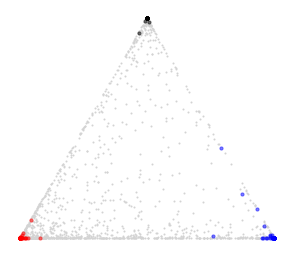

In [ ]:
cols = ('r','b','k')
fig1,ax1=plt.subplots(1,1,figsize=(5,5))
ax1.scatter(w_bary[0,~gfs.any(0),0],w_bary[0,~gfs.any(0),1],1,'lightgray')
for k in range(3):
    ax1.scatter(w_bary[0,gfs[k],0],w_bary[0,gfs[k],1],10,cols[k],alpha=0.5)
ax1.axis('off')
ax1.set_aspect('equal')

In [ ]:
gn = sd_arr[0].gene_names

In [ ]:
gfs = [gf_gou,gf_cir,gf_ext]

In [ ]:
chisq_thr = 5
gene_inds_kept = []
for model_ind in range(n_models):
    n_genes = gfs[model_ind].sum()
    gene_inds = np.where(gfs[model_ind])[0]
    keep = np.zeros((n_genes,n_subcluster_datasets),dtype=bool)
    pval = np.zeros((n_genes,n_subcluster_datasets))
    for gene_count,gene_ind in enumerate(gene_inds):
        for dataset in range(n_subcluster_datasets):
            lm = [sd_arr[dataset].M[gene_ind], sd_arr[dataset].N[gene_ind]]
            pars = sr_arr[dataset][model_ind].phys_optimum[gene_ind]
            expect_freq = sr_arr[dataset][model_ind].model.eval_model_pss(pars,lm) * sd_arr[dataset].n_cells
            
            unique_values,counts = np.unique(np.vstack(\
                       (sd_arr[dataset].U[gene_ind],sd_arr[dataset].S[gene_ind])).astype(int),axis=1,\
                        return_counts=True) #create the dataset of observed counts
            expect_freq = expect_freq[unique_values[0],unique_values[1]]
                #the added bin accounts for all the stuff that's not in the 
                #observed categories
            expect_freq = np.concatenate((expect_freq,[sd_arr[dataset].n_cells-expect_freq.sum()]))
            counts = np.concatenate((counts,[0])) 
            
            filt = (expect_freq>chisq_thr) & (counts>chisq_thr)
            observed = np.concatenate((counts[filt],[counts[~filt].sum()]))
            proposed = np.concatenate((expect_freq[filt],[expect_freq[~filt].sum()])) #this is incredibly severe.
            csq = scipy.stats.mstats.chisquare(observed, proposed, 3) #3 dof because models have 3 parameters...
            pval[gene_count,dataset] = csq.pvalue
            if csq.pvalue>0.01:
                keep[gene_count,dataset] = True
                
    gene_inds_kept.append(gene_inds[keep.all(1)])

In [ ]:
n_cells = np.asarray([sd.n_cells for sd in sd_arr])
subtype_weights = n_cells/n_cells.sum()

In [ ]:
results = []
for model_ind in range(n_models):
    data = {'meta':models[model_ind],'genes':gn[gene_inds_kept[model_ind]],'aic':w[:,:,gene_inds_kept[model_ind]]}
    n_genes = len(data['genes'])
    pars = np.zeros((n_genes,n_subcluster_datasets,3))
    for gene_count,gene_ind in enumerate(gene_inds_kept[model_ind]):
        for dataset in range(n_subcluster_datasets):
            pars[gene_count,dataset] = sr_arr[dataset][model_ind].phys_optimum[gene_ind]
    data['pars'] = pars
    data['par_initial_guess'] = (pars*subtype_weights[None,:,None]).sum(1)
    results.append(data)


In [ ]:
with open(subcluster_dir_string+'/weights_and_genes.pickle','wb') as rfs:
    pickle.dump(results,rfs)

## Out-of-sample analysis

In [ ]:
n_cores=33

In [ ]:
with open(subcluster_dir_string+'/weights_and_genes.pickle','rb') as rfs:
    results = pickle.load(rfs)

In [ ]:
loom_directory = '/home/ggorin/count_data/loom_allen_celltype_kb/test/'

In [ ]:
genes_kept = [x['genes'] for x in results]
sample_names = ['C01','B08','H12','F08']
models=('Bursty','CIR','Extrinsic')
dataset_names = ['allen_'+y+'_glu'  for y in sample_names] 
sample_looms = [loom_directory+x+'.loom' for x in dataset_names] 
gene_names_to_run = [x for x in genes_kept] #use this if you want to run everything
# gene_names_to_run = [x[:5] for x in genes_kept] #use this if you want to only run first five in each category
n_datasets = len(dataset_names)


In [ ]:
gene_names_to_run

[array(['Ddx17', 'Map3k13', 'Aftph', 'Xiap', 'Gabra4', 'Mark1', 'Btbd10',
        'Bzw2', 'Plppr5', 'Unc13a', 'Tnrc6a', 'Ldah', 'Stim1', 'Fut8',
        'Ncoa2', 'Ap3s2', 'Ppp2r3a', 'Pde2a', 'Mphosph9', 'Desi2', 'Whrn',
        'Cacna1i', 'Zmynd11', 'Pou6f1', 'Mrpl48', 'Scaper', 'Lgr4',
        'Slc16a7', 'Mgll', 'Fxr2', 'Dock9', 'Mgat4a', 'Wipf2'],
       dtype='<U16'),
 array(['Fez1', 'Tmem50b', 'Psma2', 'Smarca5', 'Aplp2', 'Tmem65', 'Camkk2',
        'Ndufv2', 'Uqcrc2', 'Bphl', 'Rheb', 'Gars', 'Ccdc136', 'Irs2',
        'Ppp1r2'], dtype='<U16'),
 array(['Sdf4', 'Srpk1', 'Srsf10', 'Actr10', 'Tmem63b', 'Celf3', 'Marf1',
        'Samd8', 'Epn1', 'Cox7a2l', 'Nucks1', 'Bace1', 'B230219D22Rik',
        'Ktn1', 'Apbb1', 'Hnrnpu', 'Pura', 'Syngap1', 'Cadm3', 'Sv2a',
        'Bclaf1'], dtype='<U16')]

In [ ]:
import multiprocessing
# pool=multiprocessing.Pool(processes=n_cores)

t1=time.time()
oss_res = {}

for test_data_ind in range(len(sample_looms)):
    print(sample_names[test_data_ind])
    with lp.connect(sample_looms[test_data_ind]) as ds:
        U = ds.layers['unspliced'][:]
        S = ds.layers['spliced'][:]
        loom_gene_names = ds.ra['gene_name']
    
    
    oos_res_dataset = {}
    for model_set in range(3):
        print(models[model_set])
        
        
        gntr = gene_names_to_run[model_set]
        gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gntr]    
        try:
            n_genes_to_run = len(gntr)
            pool = multiprocessing.Pool(processes=n_cores)
            fit_iterable = zip(U[gene_locations],\
                               S[gene_locations],\
                               [1]*n_genes_to_run,\
                               [5]*n_genes_to_run)  #maximum number of gradient descent iterations
            model_res = pool.map(par_fun_fullfit, fit_iterable)
            oos_res_dataset[models[model_set]] = model_res
            pool.close()
            pool.join()
        except:
            print('failed')
            pool.terminate()
            pool.join()
    oss_res[sample_names[test_data_ind]] = oos_res_dataset
t2 = time.time()
print('Runtime: {:.1f} minutes.'.format((t2-t1)/60))

C01
Bursty
CIR
Extrinsic
B08
Bursty


In [ ]:
lik_ratios_oos = [[[z[0] for z in oss_res[x][y]] for y in models] for x in sample_names]

In [ ]:
indices = [np.arange(0,len(gene_names_to_run[0])), \
           np.arange(len(gene_names_to_run[0]), len(gene_names_to_run[0]) + len(gene_names_to_run[1])),\
           np.arange(len(gene_names_to_run[0]) + len(gene_names_to_run[1]), \
                                                len(gene_names_to_run[0]) + len(gene_names_to_run[1]) + len(gene_names_to_run[2]))]

Visualize raw results.

In [ ]:
colors= ('r','b','k')
for test_data_ind in range(len(sample_names)):
    for model_set in range(3):
        plt.scatter(indices[model_set],lik_ratios_oos[test_data_ind][model_set],c=colors[model_set])
plt.ylim([-100,100])
plt.plot([0,sum([len(x) for x in indices])],[0,0],'g-')

In [ ]:
colors= ('salmon','royalblue','grey')
fig1,ax1 = plt.subplots(1,1,figsize=(15,4))
for model_set in range(3):
    d = np.asarray([lik_ratios_oos[test_data_ind][model_set] for test_data_ind in range(len(sample_looms))])
    bplot = ax1.boxplot(d,positions=indices[model_set],vert=True,patch_artist=True)
    for patch in bplot['boxes']:
        patch.set_facecolor(colors[model_set])
    for median in bplot['medians']:
        median.set_color('k')
#     print(bplot)
#     for test_data_ind in range(len(sample_looms)):
#         plt.scatter(indices[model_set],lik_ratios_oos[test_data_ind][model_set],c=colors[model_set])
ax1.set_ylim([-200,200])
ax1.plot([0,sum([len(x) for x in indices])],[0,0],'g-')
_=ax1.set_xticks(np.concatenate(indices),np.concatenate(gene_names_to_run),rotation=90)

In [ ]:
colors= ('salmon','royalblue','grey')
fig1,ax1 = plt.subplots(1,1,figsize=(12,4))
for model_set in range(3):
    d = np.asarray([lik_ratios_oos[test_data_ind][model_set] for test_data_ind in range(len(sample_looms))])
    ax1.scatter(indices[model_set],d.mean(0),c=colors[model_set])
ax1.set_ylim([-200,200])
ax1.plot([0,1+sum([len(x) for x in indices])],[0,0],'g-')
_=ax1.set_xticks(np.concatenate(indices),np.concatenate(gene_names_to_run),rotation=90)

In [ ]:
with open(subcluster_dir_string+'/logl_fit_results_multis_full_220806.pickle','wb') as rfs:
    pickle.dump((oss_res,lik_ratios_oos,sample_names,models,gene_names_to_run),rfs)

## SDE goodness of fit

Some of the fits are giving unrealistic and inconsistent likelihood ratios, likely due to suboptimal convergence. In principle, we could fix this by running a lot more trials, or by using Bayes factors, but this is not really practical for exploratory analysis. Instead, we can run another GOF test and throw away fits (and LRs) that are wildly inconsistent with data ($p<10^{-6}$).

In [ ]:
gou_pars  = np.array([[np.asarray([z[1] for z in oss_res[x][y]]) for y in models] for x in sample_names],dtype=object)
cir_pars  = np.array([[np.asarray([z[2] for z in oss_res[x][y]]) for y in models] for x in sample_names],dtype=object)

In [ ]:
gou_pars[1][0].shape

(5, 5)

In [ ]:
import copy
lik_ratios_checked = np.array(copy.copy([[[z[0] for z in oss_res[x][y]] for y in models] for x in sample_names]),dtype=object)
chisq_thr=5
for test_data_ind in range(len(sample_looms)):
    print(sample_names[test_data_ind])
    with lp.connect(sample_looms[test_data_ind]) as ds:
        U = ds.layers['unspliced'][:]
        S = ds.layers['spliced'][:]
        loom_gene_names = ds.ra['gene_name']
    n_cells = S.shape[1]
    for model_set in range(3):
        print(models[model_set])
        gntr = gene_names_to_run[model_set]
        gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gntr]
#         print(loom_gene_names[gene_locations])
        for gene_count,gene_ind in enumerate(gene_locations):
            lm = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int) 
            
            pval = []
            for which_model in ('gou','cir'):
                if which_model == 'gou':
                    par_array = gou_pars
                    lik_fun = get_GOU_2sp
                elif which_model == 'cir':
                    par_array = cir_pars
                    lik_fun = get_CIR_2sp
                    
                pars_gene = par_array[test_data_ind,model_set][gene_count]
                expect_freq = lik_fun(lm,pars_gene) * n_cells

                unique_values,counts = np.unique(np.vstack((U[gene_ind],S[gene_ind])).astype(int),axis=1,return_counts=True) 

                expect_freq = expect_freq[unique_values[0],unique_values[1]]

                expect_freq = np.concatenate((expect_freq,[n_cells-expect_freq.sum()]))
                counts = np.concatenate((counts,[0]))

                filt = (expect_freq>chisq_thr) & (counts>chisq_thr)

                observed = np.concatenate((counts[filt],[counts[~filt].sum()]))
                proposed = np.concatenate((expect_freq[filt],[expect_freq[~filt].sum()])) #this is incredibly severe.
                csq = scipy.stats.mstats.chisquare(observed, proposed, 4) #there are four parameters.
                pval.append(csq.pvalue)
            if (np.asarray(pval)<1e-6).any():
                lik_ratios_checked[test_data_ind,model_set][gene_count] = np.nan

C01
Bursty
CIR
Extrinsic
B08
Bursty
CIR
Extrinsic
H12
Bursty
CIR
Extrinsic
F08
Bursty
CIR
Extrinsic


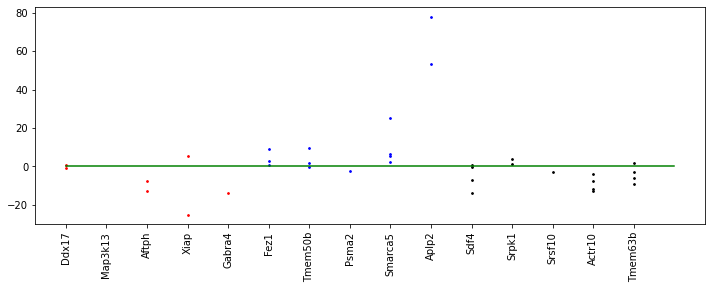

In [ ]:
colors= ('r','b','k')
fig1,ax1 = plt.subplots(1,1,figsize=(12,4))

for test_data_ind in range(len(sample_names)):
    for model_set in range(3):
        plt.scatter(indices[model_set],lik_ratios_checked[test_data_ind][model_set],3,c=colors[model_set])
# plt.ylim([-100,100])
plt.plot([0,sum([len(x) for x in indices])],[0,0],'g-')
_=plt.xticks(np.concatenate(indices),np.concatenate(gene_names_to_run),rotation=90)

/tmp/ipykernel_2749744/553159084.py:9: RuntimeWarning: Mean of empty slice
  d_mean[gene] = np.nanmean(d[:,gene])


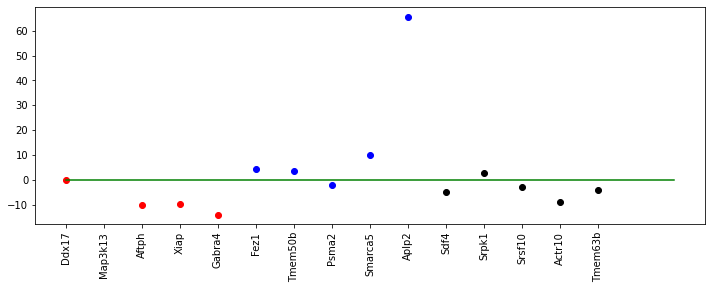

In [ ]:
colors= ('r','b','k')
fig1,ax1 = plt.subplots(1,1,figsize=(12,4))
for model_set in range(n_models):
    d = np.asarray([lik_ratios_checked[test_data_ind][model_set] for test_data_ind in range(n_datasets)])
    ng = len(gene_names_to_run[model_set])
    d_mean = np.empty(ng)
    for gene in range(ng):
        try: 
            d_mean[gene] = np.nanmean(d[:,gene])
        except:
            pass
    ax1.scatter(indices[model_set],d_mean,c=colors[model_set])

ax1.plot([0,1+sum([len(x) for x in indices])],[0,0],'g-')
_=ax1.set_xticks(np.concatenate(indices),np.concatenate(gene_names_to_run),rotation=90)

## Visualization of results

In [ ]:
gene_names_to_run

[array(['Ddx17', 'Map3k13', 'Aftph', 'Xiap', 'Gabra4'], dtype='<U16'),
 array(['Fez1', 'Tmem50b', 'Psma2', 'Smarca5', 'Aplp2'], dtype='<U16'),
 array(['Sdf4', 'Srpk1', 'Srsf10', 'Actr10', 'Tmem63b'], dtype='<U16')]

In [ ]:

test_data_ind = 3

with lp.connect(sample_looms[test_data_ind]) as ds:
    print(sample_looms[test_data_ind])
    U = ds.layers['unspliced'][:]
    S = ds.layers['spliced'][:]
    loom_gene_names = ds.ra['gene_name']

/home/ggorin/count_data/loom_allen_celltype_kb/test/allen_F08_glu.loom


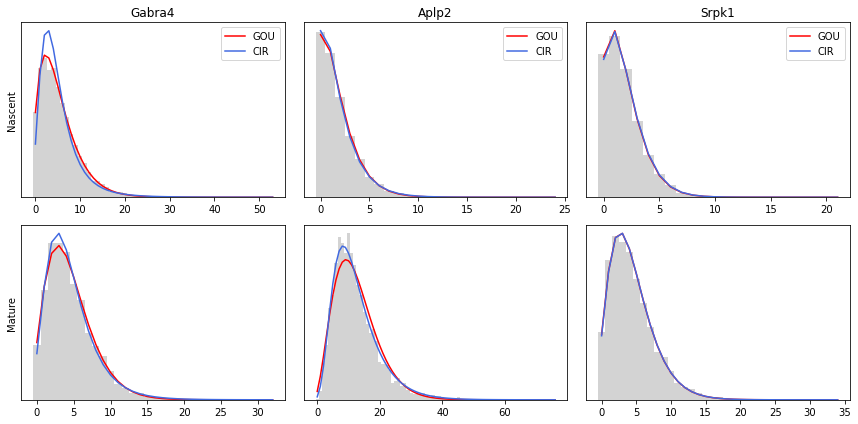

In [ ]:
genes_to_plot = ['Gabra4','Aplp2','Srpk1']

####
n_genes_to_plot= len(genes_to_plot)

gou_color='r'
cir_color='royalblue'

fig1,ax1=plt.subplots(2,n_genes_to_plot,figsize=(4*n_genes_to_plot,6))

gene_locations = np.asarray([np.where(loom_gene_names==x)[0][0] for x in genes_to_plot])

for k,gene_ind in enumerate(gene_locations):
    gene_name = genes_to_plot[k]
    model_set = np.where([gene_name in x for x in gene_names_to_run])[0][0]
    location_in_model_set = np.where(gene_name == gene_names_to_run[model_set])[0][0]
#     print([gene_name == gene_names_to_run[model_set]])
#     print(location_in_model_set)
    
    mx = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int)

    bins = np.arange(mx[0]-8)-0.5
    ax1[0,k].hist(U[gene_ind],bins,color='lightgray',density=True)
    ax1[0,k].set_title(loom_gene_names[gene_ind])
    
#     print(sample_names[test_data_ind])
    pars_sde_gou = oss_res[sample_names[test_data_ind]][models[model_set]][location_in_model_set][1]
    pars_sde_cir = oss_res[sample_names[test_data_ind]][models[model_set]][location_in_model_set][2]

    y = get_GOU_2sp([mx[0],1],pars_sde_gou)
    ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp([mx[0],1],pars_sde_cir)
    ax1[0,k].plot(y,'-',color=cir_color,label='CIR')
    ax1[0,k].legend()

    bins = np.arange(mx[1]-8)-0.5
    ax1[1,k].hist(S[gene_ind],bins,color='lightgray',density=True)

#     ax1[0,k].set_yscale('log')
#     ax1[1,k].set_yscale('log')
    
    y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
    ax1[1,k].plot(y,'-',color=gou_color)
    y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
    ax1[1,k].plot(y,'-',color=cir_color)
    
    ax1[0,k].set_yticks([])
    ax1[1,k].set_yticks([])
    if k==0:
        ax1[0,k].set_ylabel('Nascent')
        ax1[1,k].set_ylabel('Mature')
fig1.tight_layout()

In [ ]:
# oss_res[sample_names[test_data_ind]]

In [ ]:
genid

0

# Out-of-sample data analysis

In [ ]:
# n_restarts = 4

In [ ]:
cell_type_names = ['C01','B08','H12','F08']
dataset_names = ['allen_'+y+'_glu'  for y in cell_type_names] 
cell_type_looms = ['/home/ggorin/count_data/loom_allen_celltype_kb/test/'+x+'.loom' for x in dataset_names] 
test_data_ind = 2
with lp.connect(cell_type_looms[test_data_ind]) as ds:
    U = ds.layers['unspliced'][:]
    S = ds.layers['spliced'][:]
    loom_gene_names = ds.ra['gene_name']

    genes_to_run = [x[:5] for x in gene_inds_kept]
    
    model_set = 0
    try:
        gtr = genes_to_run[model_set]
        gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[gtr]]
        n_genes_to_run = len(gtr)
        pool = multiprocessing.Pool(processes=n_cores)
        fit_iterable = zip(U[gene_locations],\
                           S[gene_locations],\
                           [1]*n_genes_to_run,\
                           [10]*n_genes_to_run)
        gou_results_test = pool.map(par_fun_fullfit, fit_iterable)
        pool.close()
        pool.join()
    except:
        print('failed')
        pool.terminate()
        pool.join()

#     genes_to_run = [x for x in gene_inds_kept]

In [ ]:
# oss_res[sample_names[0]][models[2]]

(array([  9.,  15.,  43.,  75., 101., 147., 165., 190., 212., 223., 248.,
        246., 266., 239., 215., 207., 177., 158., 140.,  83.,  72.,  36.,
         26.,  17.,  14.,   6.,   2.,   0.,   2.,   1.]),
 array([4.217984 , 4.24972  , 4.2814565, 4.3131924, 4.3449283, 4.376664 ,
        4.4084005, 4.4401364, 4.4718723, 4.5036087, 4.5353446, 4.5670805,
        4.598817 , 4.630553 , 4.6622887, 4.694025 , 4.725761 , 4.757497 ,
        4.7892327, 4.820969 , 4.852705 , 4.884441 , 4.9161773, 4.947913 ,
        4.979649 , 5.011385 , 5.0431213, 5.074857 , 5.106593 , 5.1383295,
        5.1700654], dtype=float32),
 <BarContainer object of 30 artists>)

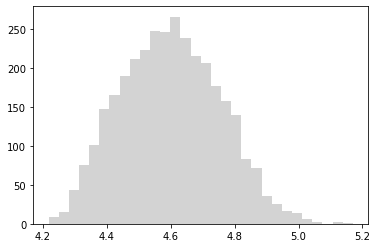

In [ ]:
total_UMIs = U.sum(0)+S.sum(0)
plt.hist(np.log10(total_UMIs),30,color='lightgray')

In [ ]:
d_mean[0]

7.200000000000003

In [ ]:
n_datasets

4

In [ ]:
gntr

array(['Ddx17', 'Map3k13', 'Aftph', 'Xiap', 'Gabra4', 'Mark1', 'Btbd10',
       'Bzw2', 'Plppr5', 'Unc13a', 'Tnrc6a', 'Ldah', 'Stim1', 'Fut8',
       'Ncoa2', 'Ap3s2', 'Ppp2r3a', 'Pde2a', 'Mphosph9', 'Desi2', 'Whrn',
       'Cacna1i', 'Zmynd11', 'Pou6f1', 'Mrpl48', 'Scaper', 'Lgr4',
       'Slc16a7', 'Mgll', 'Fxr2', 'Dock9', 'Mgat4a', 'Wipf2'],
      dtype='<U16')

In [ ]:
1e5

100000.0

In [ ]:
cf = np.log10(total_UMIs)<5
U=U[:,cf]
S=S[:,cf]

In [ ]:
cf.sum()

3318

In [ ]:
n_cores = 20

In [ ]:
gene_inds_kept

[array([  85,  116,  161,  417,  449,  482,  687,  762,  781,  960, 1145,
        1292, 1303, 1351, 1355, 1404, 1496, 1555, 1633, 1664, 1813, 1988,
        2069, 2308, 2491, 2558, 2577, 2587, 2606, 2648, 2691, 2895, 2967]),
 array([  44,  146,  180,  314,  639,  715,  837,  887, 1756, 1809, 1826,
        1949, 2429, 2748, 2878]),
 array([ 227,  692,  708,  805,  926,  945, 1053, 1425, 1610, 1619, 1886,
        2073, 2076, 2127, 2158, 2343, 2487, 2545, 2768, 2913, 2973])]

In [ ]:
genes_to_run = [x[:5] for x in gene_inds_kept]
genes_to_run = [x for x in gene_inds_kept]

In [ ]:
genes_to_run[0]

array([  85,  116,  161,  417,  449,  482,  687,  762,  781,  960, 1145,
       1292, 1303, 1351, 1355, 1404, 1496, 1555, 1633, 1664, 1813, 1988,
       2069, 2308, 2491, 2558, 2577, 2587, 2606, 2648, 2691, 2895, 2967])

In [ ]:
model_set = 0
try:
    gtr = genes_to_run[model_set]
    gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[gtr]]
    n_genes_to_run = len(gtr)
    pool = multiprocessing.Pool(processes=n_cores)
    fit_iterable = zip(U[gene_locations],\
                       S[gene_locations],\
                       [1]*n_genes_to_run,\
                       [10]*n_genes_to_run)
    gou_results_test = pool.map(par_fun_fullfit, fit_iterable)
    pool.close()
    pool.join()
except:
    print('failed')
    pool.terminate()
    pool.join()


In [ ]:
# genes_to_run[model_set]

In [ ]:
# gn[gtr]

In [ ]:
# gtr = genes_to_run[0]
# gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[gtr]]

In [ ]:
# loom_gene_names[gene_locations]

In [ ]:
# U.shape

In [ ]:
# fitit = list(zip(U[gene_locations],\
#                S[gene_locations],\
#                [5]*n_genes_to_run,\
#                [10]*n_genes_to_run))[2]
# par_fun_fullfit(fitit)

In [ ]:
# Um = U[gene_locations[0]].mean()
# Uv = U[gene_locations[0]].var()
# Sm = S[gene_locations[0]].mean()
# Sv = S[gene_locations[0]].var()

# beta = 1/Um #assuming <k>=1
# gamma = 1/Sm
# kappa = beta / ( (Sv - Sm)/(Uv - Um) * Um * (beta + gamma) / (Sm*beta) - 1) - gamma
# theta = (kappa+beta)/Um * (Uv - Um)


In [ ]:
# a = kappa/theta

In [ ]:
# np.asarray([beta,gamma,kappa,theta])/a

In [ ]:
# get_MoM(U[gene_locations[2]],S[gene_locations[2]])

In [ ]:
# fitit = list(zip(U[gene_locations],\
#                S[gene_locations],\
#                results[model_set]['par_initial_guess'][:n_genes_to_run],\
#                ['fast']*n_genes_to_run))[0]
# par_fun_fullfit(fitit)

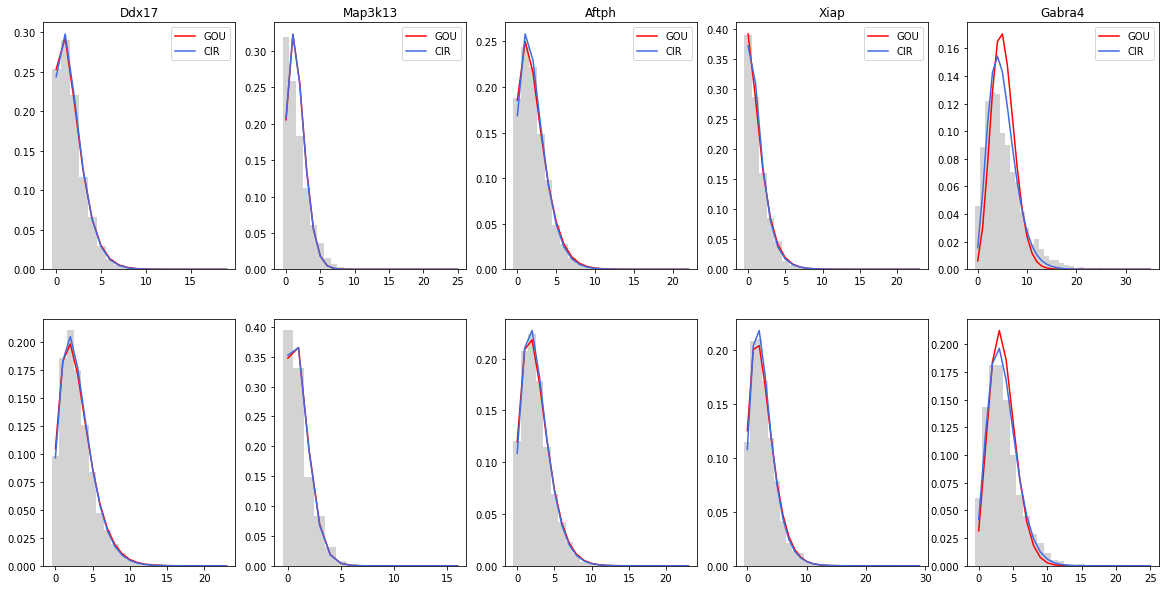

In [ ]:
fig1,ax1=plt.subplots(2,5,figsize=(20,10))

gou_reduced_color='lightcoral'
cir_reduced_color='skyblue'
gou_color='r'
cir_color='royalblue'

model_set=0
gtr = genes_to_run[model_set]
gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[gtr]]


for k,gene_ind in enumerate(gene_locations[:5]):
    mx = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int)

    bins = np.arange(mx[0]-8)-0.5
    ax1[0,k].hist(U[gene_ind],bins,color='lightgray',density=True)
    ax1[0,k].set_title(loom_gene_names[gene_ind])
    
    pars_sde_gou = gou_results_test[k][1]
    pars_sde_cir = gou_results_test[k][2]

    y = get_GOU_2sp([mx[0],1],pars_sde_gou)
    ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp([mx[0],1],pars_sde_cir)
    ax1[0,k].plot(y,'-',color=cir_color,label='CIR')
    ax1[0,k].legend()

    bins = np.arange(mx[1]-8)-0.5
    ax1[1,k].hist(S[gene_ind],bins,color='lightgray',density=True)

    y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
    ax1[1,k].plot(y,'-',color=gou_color)
    y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
    ax1[1,k].plot(y,'-',color=cir_color)


In [ ]:
model_set = 1
try:
    gtr = genes_to_run[model_set]
    gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[gtr]]
    n_genes_to_run = len(genes_to_run)
    pool = multiprocessing.Pool(processes=n_cores)
    fit_iterable = zip(U[gene_locations],\
                       S[gene_locations],\
                       [1]*n_genes_to_run,\
                       [10]*n_genes_to_run)
    cir_results_test = pool.map(par_fun_fullfit, fit_iterable)
    pool.close()
    pool.join()
except:
    print('failed')
    pool.terminate()
    pool.join()


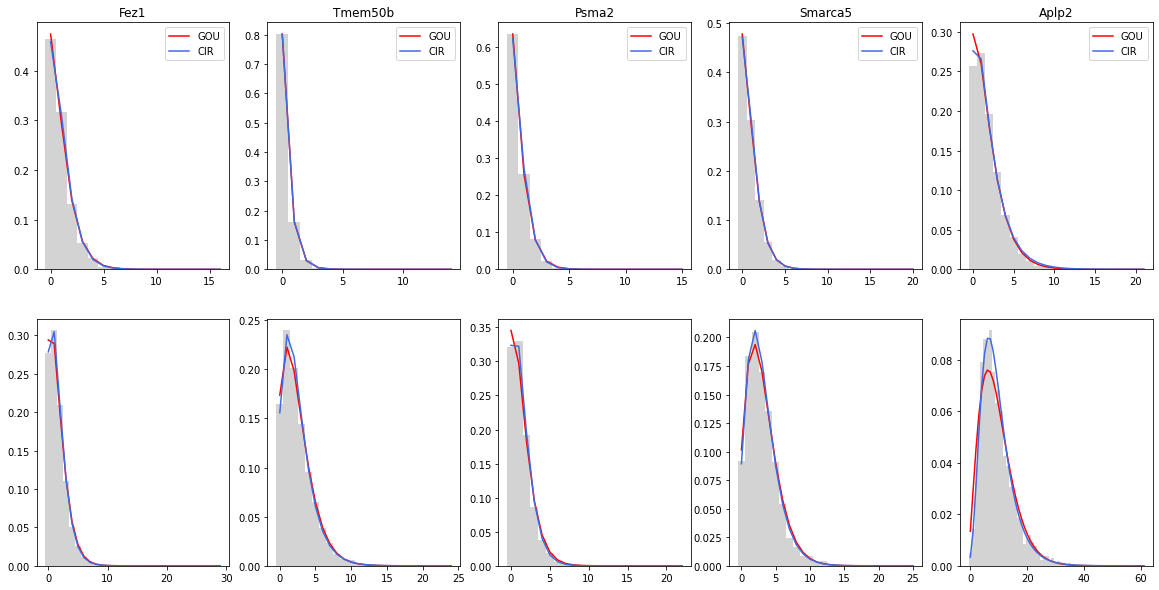

In [ ]:
fig1,ax1=plt.subplots(2,5,figsize=(20,10))

model_set=1
genes_to_run = gene_inds_kept[model_set]
gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[genes_to_run]]


gou_reduced_color='lightcoral'
cir_reduced_color='skyblue'
gou_color='r'
cir_color='royalblue'

for k,gene_ind in enumerate(gene_locations[:5]):
    mx = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int)

    bins = np.arange(mx[0]-8)-0.5
    ax1[0,k].hist(U[gene_ind],bins,color='lightgray',density=True)
    ax1[0,k].set_title(loom_gene_names[gene_ind])
    
    pars_sde_gou = cir_results_test[k][1]
    pars_sde_cir = cir_results_test[k][2]

    y = get_GOU_2sp([mx[0],1],pars_sde_gou)
    ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp([mx[0],1],pars_sde_cir)
    ax1[0,k].plot(y,'-',color=cir_color,label='CIR')
    ax1[0,k].legend()

    bins = np.arange(mx[1]-8)-0.5
    ax1[1,k].hist(S[gene_ind],bins,color='lightgray',density=True)

    y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
    ax1[1,k].plot(y,'-',color=gou_color)
    y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
    ax1[1,k].plot(y,'-',color=cir_color)


In [ ]:
model_set = 2
try:
    gtr = genes_to_run[model_set]
    gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[gtr]]
    n_genes_to_run = len(genes_to_run)
    pool = multiprocessing.Pool(processes=n_cores)
    fit_iterable = zip(U[gene_locations],\
                       S[gene_locations],\
                       [1]*n_genes_to_run,\
                       [10]*n_genes_to_run)
    ext_results_test = pool.map(par_fun_fullfit, fit_iterable)
    pool.close()
    pool.join()
except:
    print('failed')
    pool.terminate()
    pool.join()


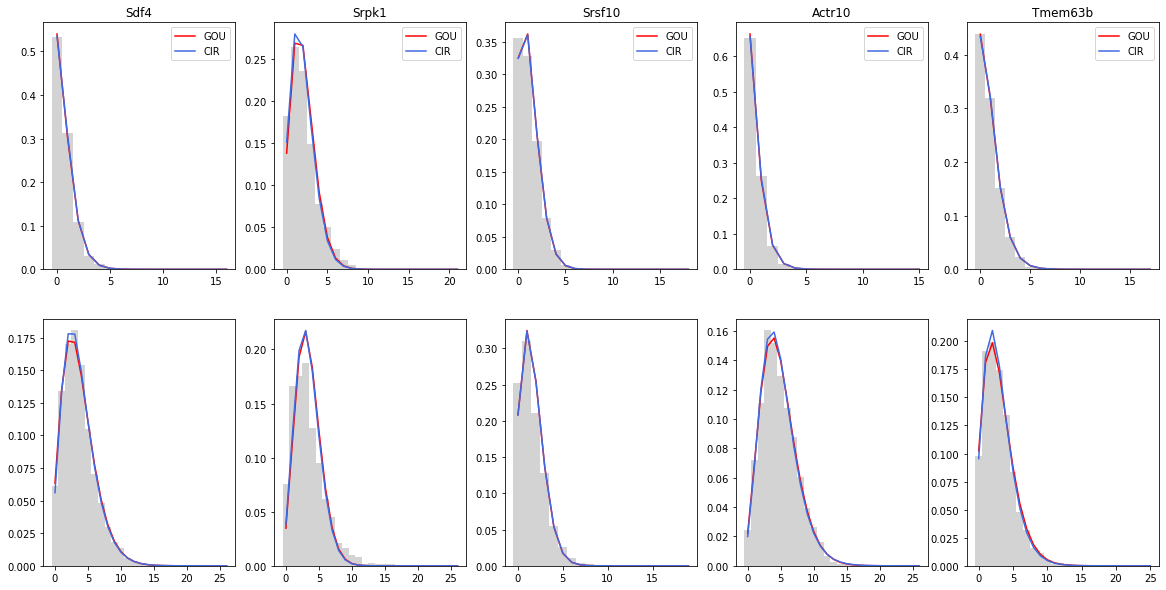

In [ ]:
fig1,ax1=plt.subplots(2,5,figsize=(20,10))
model_set=2
genes_to_run = gene_inds_kept[model_set]
gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[genes_to_run]]

gou_reduced_color='lightcoral'
cir_reduced_color='skyblue'
gou_color='r'
cir_color='royalblue'

for k,gene_ind in enumerate(gene_locations[:5]):
    mx = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int)
#     print(mx)

    bins = np.arange(mx[0]-8)-0.5
    ax1[0,k].hist(U[gene_ind],bins,color='lightgray',density=True)
    ax1[0,k].set_title(loom_gene_names[gene_ind])
    
    pars_sde_gou = ext_results_test[k][1]
    pars_sde_cir = ext_results_test[k][2]

    y = get_GOU_2sp([mx[0],1],pars_sde_gou)
    ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp([mx[0],1],pars_sde_cir)
    ax1[0,k].plot(y,'-',color=cir_color,label='CIR')
    ax1[0,k].legend()

    bins = np.arange(mx[1]-8)-0.5
    ax1[1,k].hist(S[gene_ind],bins,color='lightgray',density=True)

    y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
    ax1[1,k].plot(y,'-',color=gou_color)
    y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
    ax1[1,k].plot(y,'-',color=cir_color)


In [ ]:
lik_ratios_test = [x[0] for x in gou_results_test] + [x[0] for x in cir_results_test] + [x[0] for x in ext_results_test] 

In [ ]:
colors = ['k']*len(gou_results_test) + ['b']*len(cir_results_test) + ['g']*len(ext_results_test)

(-100.0, 100.0)

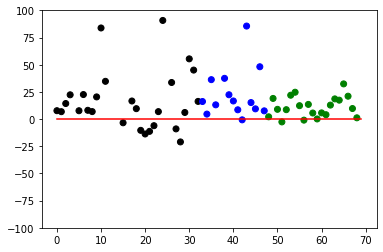

In [ ]:
plt.scatter(range(len(lik_ratios_test)),lik_ratios_test,color=colors)
plt.plot([0,len(lik_ratios_test)],[0,0],'r-')
plt.ylim([-100,100])

In [ ]:
lik_ratios_test

[7.72105727285998,
 6.810173459287398,
 14.312122459081365,
 22.333598149807585,
 932.3403535063626,
 7.680938496272574,
 22.568180641388608,
 8.079140588817609,
 6.888274379407449,
 20.393843703586754,
 83.80570244158662,
 34.73125677266398,
 -136.16996705380552,
 -222.68177768377063,
 -540.3706391576052,
 -3.3960317311375547,
 313.4579605760864,
 16.637272996191314,
 9.589947460270196,
 -10.362078882368223,
 -13.705297189482735,
 -11.291369203523573,
 -6.076023133649869,
 6.859274254153206,
 90.72052168455775,
 686.6689101268694,
 33.655304685032206,
 -9.017056333228538,
 -21.01335935341376,
 6.080175650185993,
 55.39673145717097,
 45.06477726488629,
 16.25486396420274,
 16.15337873649878,
 4.589969131793623,
 36.272693466547935,
 13.104795117871618,
 108.89536361677165,
 37.4806148134212,
 22.383820720689982,
 16.653296833150307,
 8.543148165445018,
 -0.6926291460586071,
 85.56215575681563,
 15.199928567129973,
 9.413097815144283,
 48.13356606174057,
 7.576091924256616,
 2.096803268

In [ ]:
with open('/home/ggorin/projects/GVFP_2021/fits/gg_220802_022_allen_celltypes_1/logl_fit_results.pickle','wb') as rfs:
    pickle.dump((gou_results_test,cir_results_test,ext_results_test),rfs)

In [ ]:
model_gou = CMEModel('Bursty','None')
model_cir = CMEModel('CIR','None')

In [ ]:
reduced_guess = results[0]['par_initial_guess'][0]
pars_sde_gou = convert_pars(get_MLE('GOU',sd_arr[dataset],gene_ind,reduced_guess,disp=False))
pars_sde_cir = convert_pars(get_MLE('CIR',sd_arr[dataset],gene_ind,reduced_guess,disp=False))

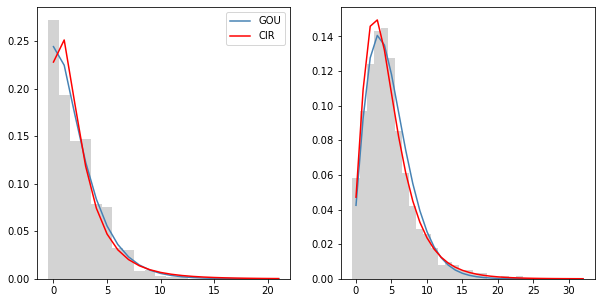

In [ ]:
fig1,ax1=plt.subplots(1,2,figsize=(10,5))

# pars = results[0]['pars'][0,0]
# raw_pars = 10**pars
# pars_sde = np.zeros(5)
# pars_sde[0] = raw_pars[1]
# pars_sde[1] = raw_pars[2]
# pars_sde[2] = 1
# pars_sde[3] = 10
# pars_sde[4] = raw_pars[0]*pars_sde[3]
# print(mx)


gou_reduced_color='skyblue'
cir_reduced_color='lightcoral'
gou_color='steelblue'
cir_color='red'

bins = np.arange(mx[0]-8)-0.5
ax1[0].hist(sd_arr[dataset].U[gene_ind],bins,color='lightgray',density=True)

# print(reduced_guess)
# print(mx)
y = get_GOU_2sp([mx[0],1],pars_sde_gou)
ax1[0].plot(y,'-',color=gou_color,label='GOU')
y = get_CIR_2sp([mx[0],1],pars_sde_cir)
ax1[0].plot(y,'-',color=cir_color,label='CIR')
ax1[0].legend()

# y = model_gou.eval_model_pss(results[0]['pars'][0,0],[mx[0],1])
# ax1[0].plot(y,'-',color=gou_reduced_color)
# y = model_cir.eval_model_pss(results[0]['pars'][0,0],[mx[0],1])
# ax1[0].plot(y,'-',color=cir_reduced_color)

bins = np.arange(mx[1]-8)-0.5
ax1[1].hist(sd_arr[dataset].S[gene_ind],bins,color='lightgray',density=True)

y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
ax1[1].plot(y,'-',color=gou_color)
y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
ax1[1].plot(y,'-',color=cir_color)

# y = model_gou.eval_model_pss(results[0]['pars'][0,0],[1,mx[1]])
# ax1[1].plot(y,'-',color=gou_reduced_color)
# y = model_cir.eval_model_pss(results[0]['pars'][0,0],[1,mx[1]])
# ax1[1].plot(y,'-',color=cir_reduced_color)



In [ ]:
pars_sde_gou

array([0.69846587, 0.34059974, 1.        , 5.33865792, 8.58307563])

In [ ]:
pars_sde_cir

array([1.11828597, 0.55709416, 1.        , 3.70344119, 9.69163971])

In [ ]:
lik_ratio, logL_gou, logL_cir = get_lik_ratio(pars_sde_gou,pars_sde_cir,sd_arr[dataset],gene_ind)

In [ ]:
np.exp(lik_ratio)

0.0008416052667578937

In [ ]:
# logL_cir

In [ ]:
results[2]['par_initial_guess']

array([[ 0.61372314,  0.71400019, -0.0534286 ],
       [ 0.49207032,  0.28764252, -0.13998206],
       [ 0.51649076,  0.33332578,  0.259165  ],
       [ 0.65798982,  0.90407471, -0.06664039],
       [ 0.50257677,  0.43672378, -0.08166862],
       [ 0.56896899,  0.32475503, -0.04905389],
       [ 0.57303585,  0.45543787, -0.22442979],
       [ 0.57096672,  0.3093385 , -0.05130626],
       [ 0.59825045,  0.57515689, -0.09370603],
       [ 0.60444444,  1.11465733, -0.27654753],
       [ 0.6247251 ,  0.85859456, -0.50929776],
       [ 0.57455281,  0.46505862, -0.04826072],
       [ 0.63296907,  0.6880956 , -0.21616537],
       [ 0.4161751 , -0.05985304, -0.10934765],
       [ 0.61699898,  0.91419371, -0.2923707 ],
       [ 0.25186238,  0.25695717, -0.21070212],
       [ 0.66102217,  0.78704108, -0.65377645],
       [ 0.60307264,  0.05641369,  0.05646185],
       [ 0.56458335,  0.75621751, -0.41151128],
       [ 0.52427475,  0.90574789, -0.17088431],
       [ 0.4134201 ,  0.25317057, -0.036